In [46]:
# Imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [47]:
x = pd.read_csv('data3/x_mat.csv')
y = pd.read_csv('data3/y_mat.csv')
sigma_x = pd.read_csv('data3/sigma_x_mat.csv')
sigma_y = pd.read_csv('data3/sigma_y_mat.csv')
sigma_xy = pd.read_csv('data3/sigma_xy_mat.csv')
x = x.to_numpy()
y = y.to_numpy()
sigma_x = sigma_x.to_numpy()
sigma_y = sigma_y.to_numpy()
sigma_xy = sigma_xy.to_numpy()

<IPython.core.display.Javascript object>


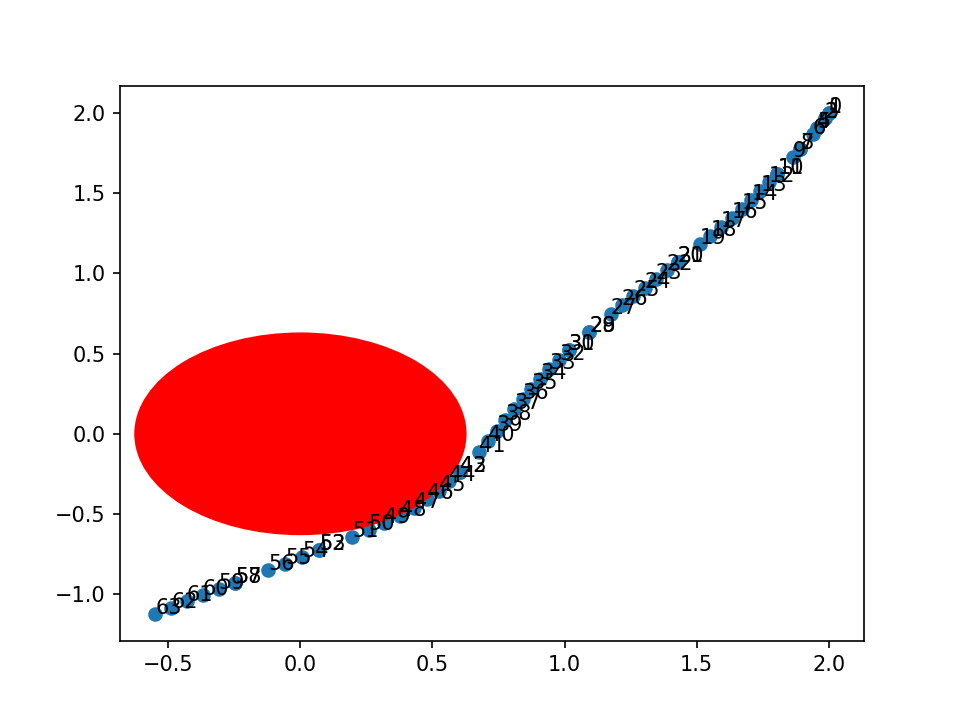

In [48]:
%matplotlib notebook
fig, ax = plt.subplots()
ax.scatter(x[:,0], y[:,0])
obst = plt.Circle((0, 0), 0.625, color='r')
ax.add_patch(obst)
for i in range(x.shape[0]):
    ax.annotate(i, (x[i,0], y[i,0]))
plt.show()

In [49]:
# Constraint checking 

x.shape

from scipy.special import erf
import math
from matplotlib.patches import Ellipse



In [50]:
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        pos = np.array([x[i,j], y[i,j]])

        sigma_x_ = sigma_x[i,j]
        sigma_y_ = sigma_y[i,j]
        sigma_xy_ = sigma_xy[i,j]
        
        Sigma = np.array([[sigma_x_, sigma_xy_], [sigma_xy_, sigma_y_]])

        epsilon = 0.05

        r_vehicle = 0.3
        r_obstacle = 0.325
        combined_radius = r_vehicle + r_obstacle
        
        obs_x = 0
        obs_y = 0

        obs_pos = np.array([obs_x, obs_y])
        diff_pos = pos - obs_pos

        a_ij = diff_pos / (np.sqrt(diff_pos.dot(diff_pos)))
        b_ij = combined_radius

        reg = 0.0316227766

        x_erfinv = 1. - 2. * epsilon

    
        z = np.sqrt(-np.log((1.0-x_erfinv) / 2.0))
        y_erfinv = (((1.641345311 * z + 3.429567803) * z - 1.624906493) * z - 1.970840454) / \
                   ((1.637067800 * z + 3.543889200) * z + 1.0)

        y_erfinv = y_erfinv - (erf(y_erfinv) - x_erfinv) / (2.0 / np.sqrt(math.pi) * np.exp(-y_erfinv * y_erfinv))
        y_erfinv = y_erfinv - (erf(y_erfinv) - x_erfinv) / (2.0 / np.sqrt(math.pi) * np.exp(-y_erfinv * y_erfinv))

        constr = a_ij.T @ diff_pos - b_ij - y_erfinv * reg * np.sqrt(2.*a_ij.T @ Sigma @ a_ij + 1e-04)
        if (constr < 0):
            print("Infeasible constraint detected: ", constr)
            print("Position", pos)
            print("Iteration i:", i, " j:", j)

In [51]:
def computeEllipseRot(l_1, a, b, c):
    if (b == 0 and a >= c):
        rot = 0
    elif (b == 0 and  a < c):
        rot = 1.57079632679
    else:
        rot = math.atan2(l_1 - a, b)
    return rot

<IPython.core.display.Javascript object>


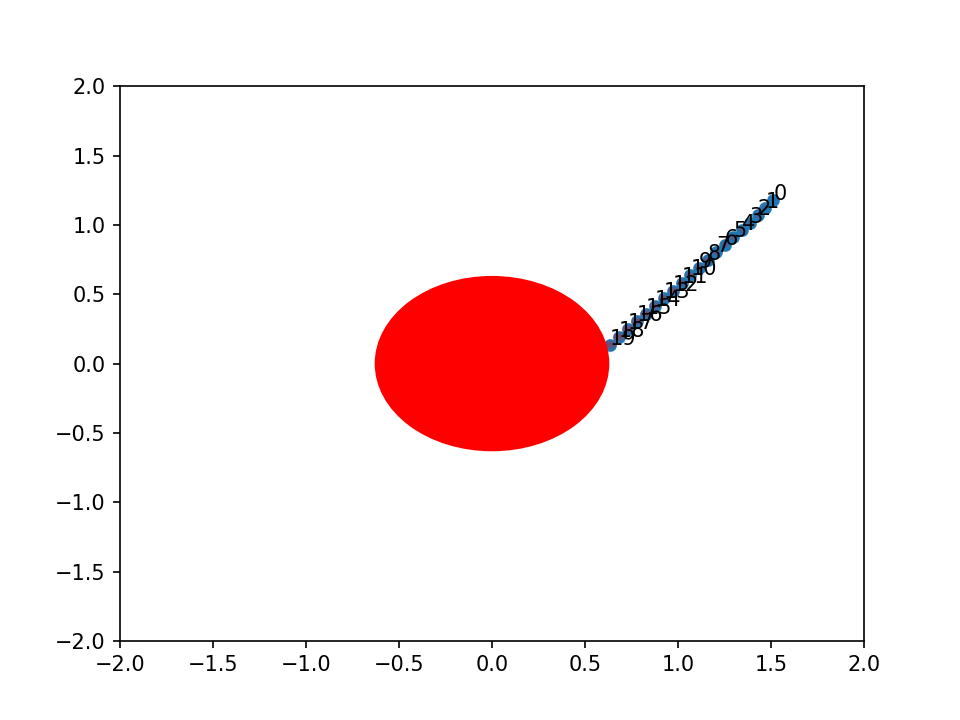

In [52]:
# Plot the unceratinty 
it = 19
%matplotlib notebook
fig, ax = plt.subplots()
ax.scatter(x[it,:], y[it,:], linewidths=0.1)
obst = plt.Circle((0, 0), 0.625, color='r')
ax.add_patch(obst)
plt.xlim(-2,2)
plt.ylim(-2,2)
for i in range(x.shape[1]):
    ax.annotate(i, (x[it,i], y[it,i]))
# Add the uncertainty ellipse
for i in range(x.shape[1]):
    variance_x = 0.001 * sigma_x[it,i]
    variance_y = 0.001 * sigma_y[it,i]
    variance_xy = 0.001 * sigma_xy[it,i]
    l_1 = 2*((variance_x + variance_y)/2 + np.sqrt(((variance_x - variance_y)/2)**2 + variance_xy**2)) * 5.991
    l_2 = 2*((variance_x + variance_y)/2 - np.sqrt(((variance_x - variance_y)/2)**2 + variance_xy**2)) * 5.991
    rot = computeEllipseRot(l_1, variance_x, variance_xy, variance_y)
    ellipse = Ellipse(xy=(x[it,i], y[it,i]), width= np.sqrt(l_1), height= np.sqrt(l_2), angle =rot, edgecolor='r', fc='r', lw=2, alpha=0.2)
    ax.add_patch(ellipse)
plt.show()

# Ellipsoidal constraints

In [53]:
def rotation_matrix(angle):
    return np.array([[np.cos(angle), -np.sin(angle)],
                      [np.sin(angle), np.cos(angle)]])

In [54]:
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        
        
        variance_x = 0.001 * sigma_x[i,j]
        variance_y = 0.001 * sigma_y[i,j]
        variance_xy = 0.001 * sigma_xy[i,j]

        l_1 = (variance_x + variance_y)/2 + np.sqrt(((variance_x - variance_y)/2) **2 + variance_xy ** 2)
        l_2 = (variance_x + variance_y)/2 - np.sqrt(((variance_x - variance_y)/2) **2 + variance_xy ** 2)
        rot = computeEllipseRot(l_1, variance_x, variance_xy, variance_y)
        
        pos = np.array([x[i,j], y[i,j]])
        r_disc = 0.03
        
        obst_x = 0
        obst_y = 0
        obst_psi = 0
        obst_major = l_1
        obst_minor = l_2
        obst_r = 0.0325

        # multiplier for the risk when obst_major, obst_major only denote the covariance
        # (i.e., the smaller the risk, the larger the ellipsoid).
        # This value should already be a multiplier (using exponential cdf).
        chi = 5.991

        # obstacle computations
        obstacle_cog = np.array([obst_x, obst_y])
        
        disc_to_obstacle = pos - obstacle_cog
        
        obst_major *= np.sqrt(chi)
        obst_minor *= np.sqrt(chi)
        ab = np.array([[1. / ((obst_major + (r_disc + obst_r)) ** 2), 0],
                       [0, 1. / ((obst_minor + (r_disc + obst_r)) ** 2)]])

        # In the original LMPCC paper the angle of the obstacles is defined clockwise
        obstacle_rotation = rotation_matrix(obst_psi)

        obstacle_ellipse_matrix = obstacle_rotation.transpose().dot(ab).dot(obstacle_rotation)

        c_disc_obstacle = disc_to_obstacle.transpose().dot(obstacle_ellipse_matrix).dot(disc_to_obstacle)
        
        if (c_disc_obstacle < 0):
            print("Infeasible constraint detected: ", c_disc_obstacle)
            print("Position", pos)
            print("Iteration i:", i, " j:", j)
        

<IPython.core.display.Javascript object>


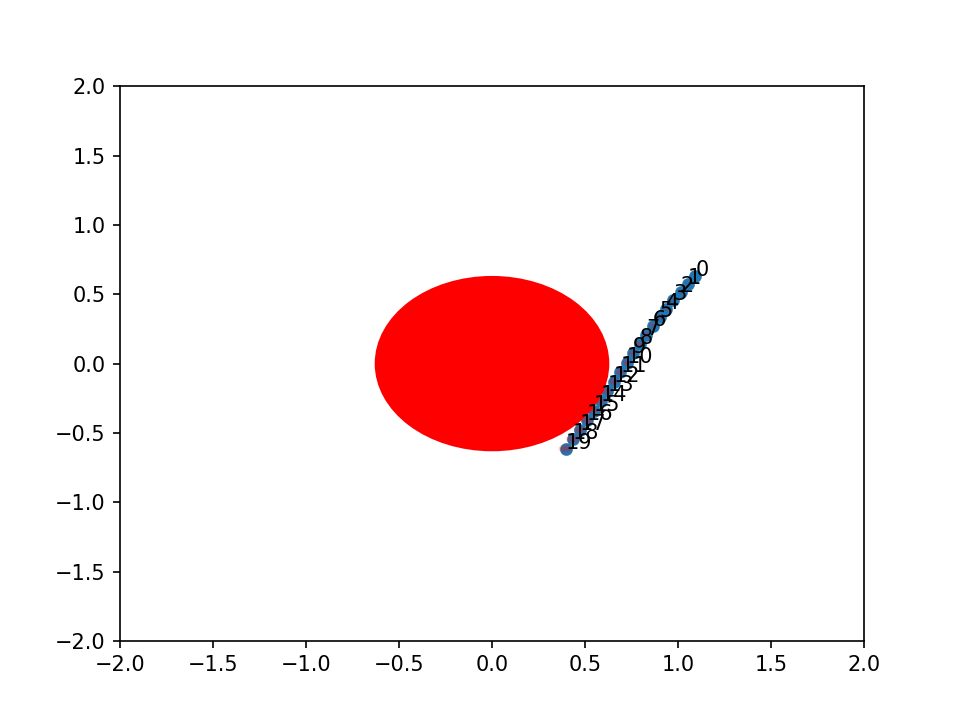

In [57]:
# Plot the unceratinty 
it = 29
%matplotlib notebook
fig, ax = plt.subplots()
ax.scatter(x[it,:], y[it,:], linewidths=0.1)
obst = plt.Circle((0, 0), 0.625, color='r')
ax.add_patch(obst)
plt.xlim(-2,2)
plt.ylim(-2,2)
for i in range(x.shape[1]):
    ax.annotate(i, (x[it,i], y[it,i]))
# Add the uncertainty ellipse
for i in range(x.shape[1]):
    variance_x = 0.001 * sigma_x[it,i]
    variance_y = 0.001 * sigma_y[it,i]
    variance_xy = 0.001 * sigma_xy[it,i]
    l_1 = 2*((variance_x + variance_y)/2 + np.sqrt(((variance_x - variance_y)/2)**2 + variance_xy**2)) * 5.991
    l_2 = 2*((variance_x + variance_y)/2 - np.sqrt(((variance_x - variance_y)/2)**2 + variance_xy**2)) * 5.991
    rot = computeEllipseRot(l_1, variance_x, variance_xy, variance_y)
    ellipse = Ellipse(xy=(x[it,i], y[it,i]), width= np.sqrt(l_1), height= np.sqrt(l_2), angle =rot, edgecolor='r', fc='r', lw=2, alpha=0.2)
    ax.add_patch(ellipse)
plt.show()

# SVD 

In [282]:
import numpy as np

sigma = [[0.61, 0],[0, 1.32]]
u, s, vh = np.linalg.svd(sigma, full_matrices=True)
print(np.diag(s))

[[1.32 0.  ]
 [0.   0.61]]


In [278]:
print(u,s)

[[0. 1.]
 [1. 0.]] [1.32 0.61]


In [279]:
u, s= np.linalg.eig(sigma)

In [280]:
print(u,s)

[0.61 1.32] [[1. 0.]
 [0. 1.]]


In [283]:
sigma_x = 0.61
sigma_y = 1.32
sigma_xy = 0
obst_major = (sigma_x + sigma_y) / 2 + np.sqrt(((sigma_x - sigma_y) / 2) ** 2 + sigma_xy ** 2 + 1e-12)
obst_minor = (sigma_x + sigma_y) / 2 - np.sqrt(((sigma_x - sigma_y) / 2) ** 2 + sigma_xy ** 2 + 1e-12)

In [284]:
print(obst_major)
print(obst_minor)

1.3200000000014085
0.6099999999985916


In [299]:
obstacle_rot = np.array([[1/np.sqrt(1+((obst_major-sigma_x)/sigma_xy)**2), 1/np.sqrt(1+((obst_minor-sigma_x)/sigma_xy)**2)],\
                [(obst_major-sigma_x)/(sigma_xy * np.sqrt(1+((obst_major-sigma_x)/sigma_xy)**2)), (obst_minor-sigma_x)/(sigma_xy * np.sqrt(1+((obst_minor-sigma_x)/sigma_xy)**2))]])

In [300]:
print(obstacle_rot)

[[ 2.81690141e-12  8.17609830e-01]
 [ 1.00000000e+00 -5.75772669e-01]]


In [298]:
sigma_xy = sigma_xy+1e-12

In [270]:
A= np.array([[1,2],[2,4]])

In [254]:
print(A)

[[1 2]
 [2 4]]


In [255]:
sigma = np.diag(s)
print(sigma)

[[0.75811046 0.        ]
 [0.         0.05803904]]


In [256]:
u @ A @ u.transpose()

array([[ 4.6862636 , -1.21253926],
       [-1.21253926,  0.3137364 ]])

In [257]:
obstacle_rot @ A @ obstacle_rot.transpose()

array([[ 4.52471881, -1.46646301],
       [-1.46646301,  0.47528119]])

In [292]:
print(u, obstacle_rot)

[[0. 1.]
 [1. 0.]] [[ 1.4084507e-12  5.7892787e-01]
 [ 1.0000000e+00 -8.1537876e-01]]


In [293]:
x = np.array([1,0])

In [294]:
v1 = u.dot(x)

In [295]:
v2 = obstacle_rot.dot(x)

In [296]:
import matplotlib.pyplot as plt
print(x,v1,v2)

[1 0] [0. 1.] [1.4084507e-12 1.0000000e+00]


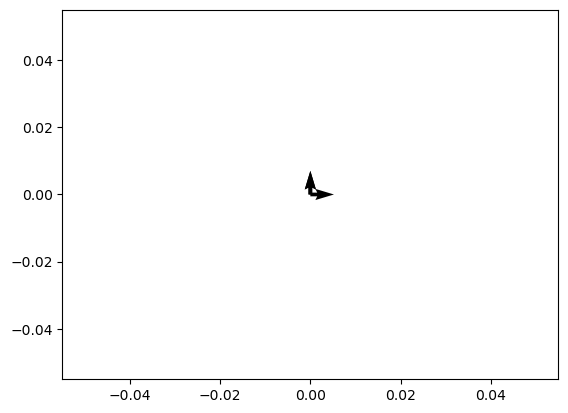

In [301]:
plt.quiver(x[0],x[1], scale=21)
plt.quiver(v1[0],v1[1], scale=21)
plt.quiver(v2[0],v2[1], scale=21)